# Tensors, version5, revision 2

## Setup packages.

In [1]:
require(abind)
require(data.table)
require(magrittr)
require(rTensor)

require(ggplot2)
require(GGally)

Loading required package: abind
Loading required package: data.table
Loading required package: magrittr
Loading required package: rTensor
Loading required package: ggplot2
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


## Read data tables.

### 3D dataset.

In [2]:
xs3d <- fread("xs-3d-20200322a.csv")[, case:=factor(case)]
xs3d %>% dim

[1] 1331    4

In [3]:
ys3d <- fread("ys-3d-20200322a.csv")[, case:=factor(case)]
ys3d %>% dim

[1] 27951     5

In [4]:
s3d <- merge(xs3d, ys3d)
s3d %>% dim

[1] 27951     8

## Reorganize as a tensor.

In [5]:
y <- array(
    as.matrix(s3d[order(t, x3, x2, x1)][, .(y1, y2, y3)]),
    dim = c(
        length(unique(s3d$x1)),
        length(unique(s3d$x2)),
        length(unique(s3d$x3)),
        length(unique(s3d$t )),
        3
    ),
    dimnames = list(
        x1=sort(unique(s3d$x1)),
        x2=sort(unique(s3d$x2)),
        x3=sort(unique(s3d$x3)),
        t =sort(unique(s3d$t )),
        i =1:3
    )
)
y %>% dim

[1] 11 11 11 21  3

## Compute differences.

### First differences (Jacobians).

In [6]:
dy1 <- y[2:11,     ,     , , ] - y[1:10,     ,     , , ]
dy2 <- y[    , 2:11,     , , ] - y[    , 1:10,     , , ]
dy3 <- y[    ,     , 2:11, , ] - y[    ,     , 1:10, , ]

dy <- abind(
    (dy1[    , 2:11, 2:11, , ] + dy1[    , 1:10, 1:10, , ]) / 2,
    (dy2[2:11,     , 2:11, , ] + dy2[1:10,     , 1:10, , ]) / 2,
    (dy3[2:11, 2:11,     , , ] + dy3[1:10, 1:10,     , , ]) / 2,
    along=6
)
dy %>% dim

[1] 10 10 10 21  3  3

### Second differences (Hessians).

In [7]:
ddy1 <- dy[2:10,     ,     , , , ] - dy[1:9,    ,    , , , ]
ddy2 <- dy[    , 2:10,     , , , ] - dy[   , 1:9,    , , , ]
ddy3 <- dy[    ,     , 2:10, , , ] - dy[   ,    , 1:9, , , ]

ddy <- abind(
    (ddy1[    , 2:10, 2:10, , , ] + ddy1[   , 1:9, 1:9, , , ]) / 2,
    (ddy2[2:10,     , 2:10, , , ] + ddy2[1:9,    , 1:9, , , ]) / 2,
    (ddy3[2:10, 2:10,     , , , ] + ddy3[1:9, 1:9,    , , , ]) / 2,
    along=7
)
ddy %>% dim

[1]  9  9  9 21  3  3  3

## Eigenvalues of the Hessian.

This is just an experiment, and I didn't pursue this far because it requires too much regularity in sampling.

### Compute the tensor.

In [8]:
cy <- array(
    0,
    dim = c(
        dim(ddy)[1],
        dim(ddy)[2],
        dim(ddy)[3],
        dim(ddy)[4],
        dim(ddy)[5],
        3
    ),
    dimnames = list(
        x1=dimnames(y)$x1[2:10],
        x2=dimnames(y)$x2[2:10],
        x3=dimnames(y)$x3[2:10],
        t =dimnames(y)$t,
        i =dimnames(y)$i,
        e =c("e1", "e2", "e3")
    )
)
for (x1 in 1:dim(cy)[1])
    for (x2 in 1:dim(cy)[2])
        for (x3 in 1:dim(cy)[3])
            for(t in 1:dim(cy)[4])
                for (i in 1:dim(cy)[5])
                    cy[x1, x2, x3, t, i, ] <- sort(eigen(ddy[x1, x2, x3, t, i, , ])$values)
cy %>% dim

[1]  9  9  9 21  3  3

### Look at some slices.

In [9]:
cy[, 5, 5, 21, 3, ]

,e1,e2,e3
0.1,0.000000,0.00000000,0.05303377
0.2,0.000000,0.00000000,0.05303377
0.3,0.000000,0.00000000,0.05303377
0.4,0.000000,0.00000000,0.05303377
0.5,-1.088146,0.00000000,0.22180704
0.6,0.000000,0.09492435,1.12622275
0.7,0.000000,0.00000000,0.30177402
0.8,0.000000,0.00000000,0.30177402
0.9,0.000000,0.00000000,0.30177402


In [10]:
cy[5, , 5, 21, 3, ]

,e1,e2,e3
0.1,-1.088146,0.00000000,0.2218070
0.2,-1.088146,0.00000000,0.2218070
0.3,-1.088146,0.00000000,0.2218070
0.4,-1.088146,0.00000000,0.2218070
0.5,-1.088146,0.00000000,0.2218070
0.6,-1.088146,0.00000000,0.2218070
0.7,-1.088146,0.00000000,0.2218070
0.8,-1.088146,0.00000000,0.2218070
0.9,-1.047872,0.05756947,0.2189628


In [11]:
cy[5, 5, , 21, 3, ]

,e1,e2,e3
0.1,-2.20301709,0.0000000,0.001645644
0.2,-2.13405883,0.0000000,0.012367898
0.3,-1.95182311,0.0000000,0.043062267
0.4,-1.60836159,0.0000000,0.105934198
0.5,-1.08814634,0.0000000,0.221807040
0.6,-0.48770813,0.0000000,0.404491013
0.7,-0.01462897,0.0000000,0.591342061
0.8,0.00000000,0.1138212,0.639566089
0.9,-0.31335437,0.0000000,0.400191869


## Tucker decomposion.

This is just an experiment, and I didn't pursue this far because it requires too much regularity in sampling.

### Try a decomposition.

In [12]:
yt <- tucker(as.tensor(y), c(3, 3, 3, 3, 3))

  |======================================================================| 100%


### Examine the results.

In [13]:
yt

$Z
Numeric Tensor of 5 Modes
Modes:  3 3 3 3 3 
Data: 
[1] -4.155819e+02  3.229759e+01  1.159814e-13 -7.646852e-01  1.591227e+00
[6]  3.377517e-16

$U
$U[[1]]
            [,1]       [,2]        [,3]
 [1,] -0.1207642 -0.3899778  0.21973641
 [2,] -0.1207642 -0.3899778 -0.04394728
 [3,] -0.1207642 -0.3899778 -0.04394728
 [4,] -0.1207642 -0.3899778 -0.04394728
 [5,] -0.1207642 -0.3899778 -0.04394728
 [6,] -0.1207642 -0.3899778 -0.04394728
 [7,] -0.4271993  0.1322905  0.44962672
 [8,] -0.4271993  0.1322905  0.30273000
 [9,] -0.4271993  0.1322905  0.30273000
[10,] -0.4271993  0.1322905 -0.52754336
[11,] -0.4271993  0.1322905 -0.52754336

$U[[2]]
            [,1]        [,2]          [,3]
 [1,] -0.3016936 -0.09476814  2.891288e-01
 [2,] -0.3016936 -0.09476814 -1.443700e-01
 [3,] -0.3016936 -0.09476814 -1.443700e-01
 [4,] -0.3016936 -0.09476814 -1.443700e-01
 [5,] -0.3016936 -0.09476814 -1.443700e-01
 [6,] -0.3016936 -0.09476814 -1.443700e-01
 [7,] -0.3016936 -0.09476814 -1.443700e-01
 [8,] -0

## Experiment with discrepancies across diagonals.

Let's fall back to something simpler. Each cell has three diagonals that cross in the center. Averaging the endpoints of each diagonal gives an estimate for the value at the center point. If the variance of the estimates based on each diagonal is a measure of the curvature over the cell. Score each cell by the maximum variance over time and over the `y1`, `y2`, and `y3`. Before doing this, it's best to scale the scale `y` dimensions separately.

In [14]:
y %>% dim

[1] 11 11 11 21  3

In [15]:
midpoints <- function(x) (x[-1] + x[-length(x)]) / 2

In [16]:
y.scaled <- apply(y, 1:4, scale)
y.scaled %>% dim

[1]  3 11 11 11 21

In [17]:
y.deltas <- array(
    0,
    dim = c(
        dim(y.scaled)[1],
        dim(y.scaled)[2] - 1,
        dim(y.scaled)[3] - 1,
        dim(y.scaled)[4] - 1,
        dim(y.scaled)[5],
        3
    ),
    dimnames = list(
        i = dimnames(y)$i,
        x1 = midpoints(as.numeric(dimnames(y.scaled)$x1)),
        x2 = midpoints(as.numeric(dimnames(y.scaled)$x2)),
        x3 = midpoints(as.numeric(dimnames(y.scaled)$x3)),
        t = dimnames(y)$t,
        d = c("+++", "++-", "+--")
    )
)
im <- 1 : dim(y.deltas)[2]
ip <- 1 + im
y.deltas[, , , , , 1] <- (y.scaled[, ip, ip, ip, ] + y.scaled[, im, im, im, ]) / 2
y.deltas[, , , , , 2] <- (y.scaled[, ip, ip, im, ] + y.scaled[, im, im, ip, ]) / 2
y.deltas[, , , , , 3] <- (y.scaled[, ip, im, im, ] + y.scaled[, im, ip, ip, ]) / 2
y.deltas %>% dim

[1]  3 10 10 10 21  3

In [18]:
y.maxdelta <- apply(
    apply(y.deltas, 1:5, sd),
    2:4,
    max
)
y.maxdelta %>% dim

[1] 10 10 10

### Organize as a data table.

In [19]:
z <- data.table(melt(y.maxdelta))[, rank := rank(value, ties="random")]
write.table(z, file="discrepancies-v5.csv", sep=",", row.names=FALSE)
z %>% head

x1,x2,x3,value,rank
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.05,0.05,0.05,0,473
0.15,0.05,0.05,0,482
0.25,0.05,0.05,0,140
0.35,0.05,0.05,0,324
0.45,0.05,0.05,0,321
0.55,0.05,0.05,0,41


### Plot slices.

#### By value.

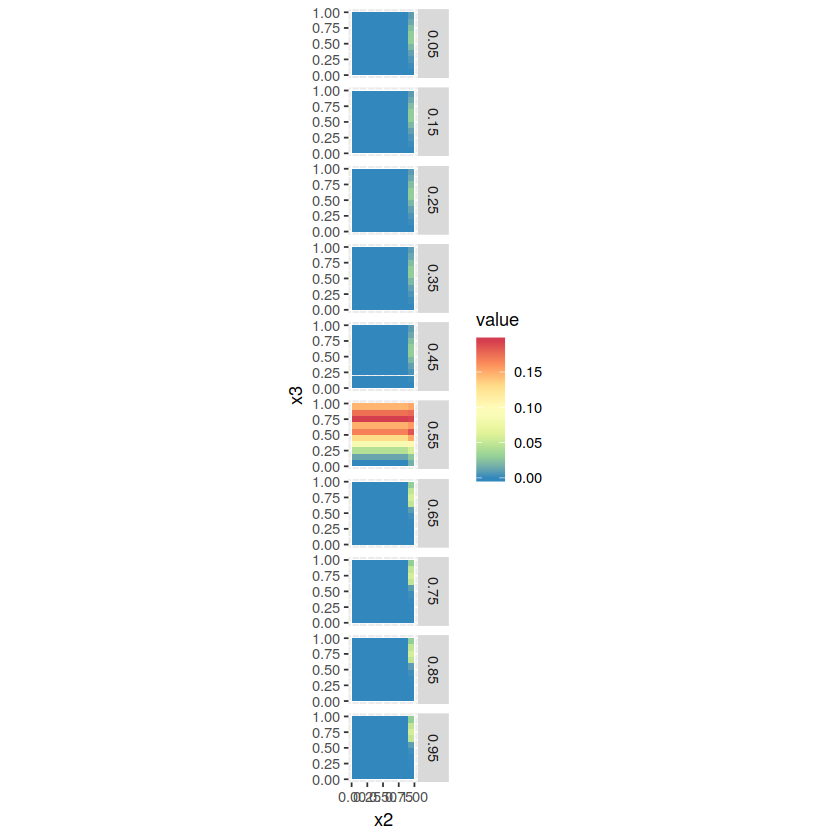

In [20]:
ggplot(z, aes(x=x2, y=x3, fill=value)) +
    geom_tile() +
    coord_fixed() +
    scale_fill_distiller(palette = "Spectral") +
    facet_grid(x1 ~ .)

#### By rank.

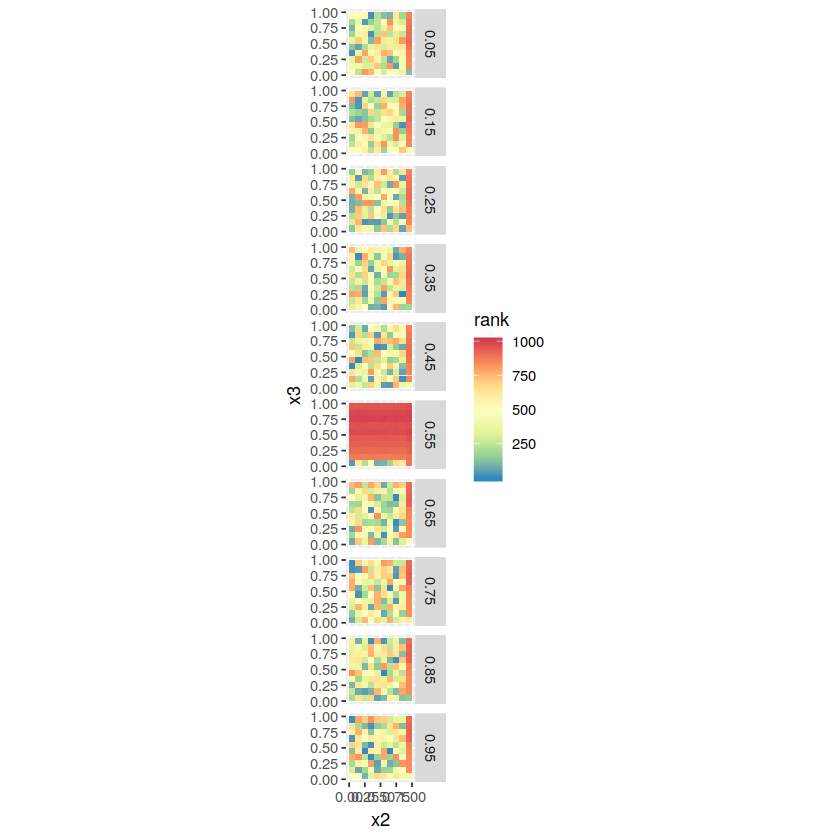

In [21]:
ggplot(z, aes(x=x2, y=x3, fill=rank)) +
    geom_tile() +
    coord_fixed() +
    scale_fill_distiller(palette = "Spectral") +
    facet_grid(x1 ~ .)

#### Add a reference plot.

Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning me

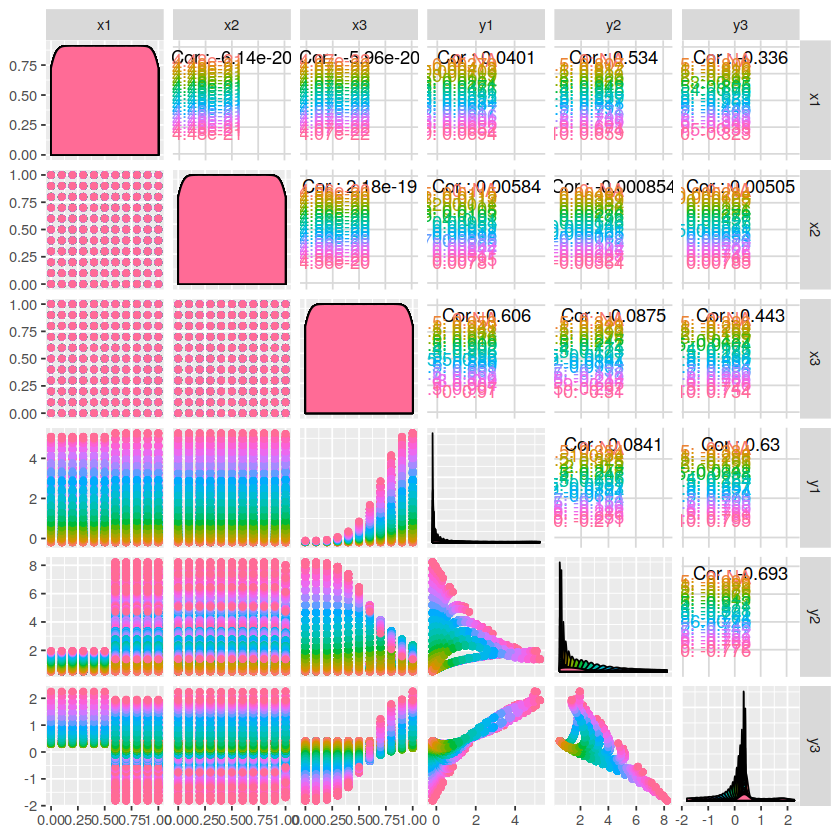

In [22]:
ggpairs(s3d, columns=c(2:4, 6:8), mapping=aes(color=factor(t)))